# Benchmarking of Embedding Evaluator
The embedding evaluator predicts the average MSE made by MS2Deepscore. 
Here we analyze the effect of removing spectra with a high predicted MSE from the benchmarking and we compare with some other methods for detecting spectrum quality.

In [1]:
import os
from ms2deepscore.MS2DeepScore import MS2DeepScore
from ms2deepscore.models.load_model import load_model
from matchms.importing.load_from_mgf import load_from_mgf
from ms2deepscore.utils import load_pickled_file
from ms2deepscore.models.load_model import load_model, load_embedding_evaluator

data_folder = os.path.join("../../../data/pytorch/new_corinna_included/")
both_mode_folder = "trained_models/both_mode_precursor_mz_ionmode_10000_layers_500_embedding_2024_11_21_11_23_17/"

# Validation spectra
pos_test_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "positive_testing_spectra.mgf")))
neg_test_spectra = list(load_from_mgf(os.path.join(data_folder, "training_and_validation_split", "negative_testing_spectra.mgf")))

ms2ds_model = load_model(os.path.join(data_folder, both_mode_folder, "ms2deepscore_model.pt"))
ms2ds_embedding_evaluator = load_embedding_evaluator(os.path.join(data_folder, both_mode_folder, "embedding_evaluator_model/embedding_evaluator.pt"))


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

### Get predicted mse on test spectra

In [2]:
from ms2deepscore.MS2DeepScore import MS2DeepScore
from tqdm import tqdm
import numpy as np

def get_predicted_mse(ms2ds_model, embedding_evaluator, spectra):
    ms2deepscore_model = MS2DeepScore(ms2ds_model)
    embeddings = ms2deepscore_model.get_embedding_array(spectra)
    predicted_mses = []
    # Batches are needed, since memory is overloaded otherwise
    batch_size = 100
    for i in tqdm(range(len(embeddings)//batch_size + 1)):
        low = i * batch_size
        high = low + batch_size
        predicted_mses.append(ms2ds_embedding_evaluator.compute_embedding_evaluations(embeddings[low : high, :]))
    return np.concatenate(predicted_mses).ravel()


In [3]:
combined_spectra =  pos_test_spectra + neg_test_spectra

In [4]:
predicted_mse = get_predicted_mse(ms2ds_model, ms2ds_embedding_evaluator, combined_spectra)

32053it [00:39, 809.22it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 170.03it/s]


### Check effect of filtering out spectra with high MSE

In [5]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
def select_nr_of_spectra(predicted_mse, nr_of_spectra, combinned_spectra):
    sorted_indexes = predicted_mse.argsort()
    selected_spectra = [combinned_spectra[index] for index in sorted_indexes[:nr_of_spectra]]

    selected_pos_spectra = []
    selected_neg_spectra = []
    for spectrum in selected_spectra:
        if spectrum.get("ionmode") == "positive":
            selected_pos_spectra.append(spectrum)
        else:
            selected_neg_spectra.append(spectrum)
    selected_scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(os.path.join(data_folder, both_mode_folder, "ms2deepscore_model.pt"), 
                                                                      selected_pos_spectra, selected_neg_spectra)
    return selected_scores_between_ionmodes

In [6]:
scores_per_nr_of_spectra = {}
for nr_of_spectra in range(5000, 36000, 5000):
    print(nr_of_spectra)
    scores_per_nr_of_spectra[nr_of_spectra] = select_nr_of_spectra(predicted_mse, nr_of_spectra, combined_spectra)

5000


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


3438it [00:04, 833.92it/s]
1562it [00:01, 822.37it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:01<00:00, 356.70it/s]


Calculating tanimoto scores
Calculating embeddings


3438it [00:04, 830.24it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 693/693 [00:01<00:00, 377.20it/s]


Calculating tanimoto scores
Calculating embeddings


1562it [00:01, 824.14it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [00:01<00:00, 354.24it/s]


Calculating tanimoto scores
10000


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


7046it [00:08, 826.53it/s]
2954it [00:03, 817.01it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:01<00:00, 381.02it/s]


Calculating tanimoto scores
Calculating embeddings


7046it [00:08, 824.09it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1259/1259 [00:03<00:00, 405.40it/s]


Calculating tanimoto scores
Calculating embeddings


2954it [00:03, 812.51it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:01<00:00, 377.37it/s]


Calculating tanimoto scores
15000
Calculating embeddings


10671it [00:13, 819.22it/s]
4329it [00:05, 796.34it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [00:01<00:00, 384.10it/s]


Calculating tanimoto scores
Calculating embeddings


10671it [00:13, 814.72it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1552/1552 [00:03<00:00, 400.75it/s]


Calculating tanimoto scores
Calculating embeddings


4329it [00:05, 804.34it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [00:02<00:00, 341.30it/s]


Calculating tanimoto scores
20000
Calculating embeddings


14431it [00:17, 804.55it/s]
5569it [00:07, 787.89it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:02<00:00, 391.66it/s]


Calculating tanimoto scores
Calculating embeddings


14431it [00:17, 812.98it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1701/1701 [00:04<00:00, 351.10it/s]


Calculating tanimoto scores
Calculating embeddings


5569it [00:07, 767.86it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:02<00:00, 312.85it/s]


Calculating tanimoto scores
25000
Calculating embeddings


18499it [00:23, 793.58it/s]
6501it [00:08, 797.08it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:02<00:00, 376.84it/s]


Calculating tanimoto scores
Calculating embeddings


18499it [00:22, 807.15it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1803/1803 [00:04<00:00, 403.07it/s]


Calculating tanimoto scores
Calculating embeddings


6501it [00:08, 780.51it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 894/894 [00:02<00:00, 360.35it/s]


Calculating tanimoto scores
30000
Calculating embeddings


22947it [00:29, 779.84it/s]
7053it [00:09, 761.42it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 919/919 [00:02<00:00, 378.27it/s]


Calculating tanimoto scores
Calculating embeddings


22947it [00:28, 795.69it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1828/1828 [00:04<00:00, 398.80it/s]


Calculating tanimoto scores
Calculating embeddings


7053it [00:09, 779.73it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 919/919 [00:03<00:00, 297.66it/s]


Calculating tanimoto scores
35000
Calculating embeddings


24911it [00:31, 779.62it/s]
7142it [00:09, 788.07it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 374.93it/s]


Calculating tanimoto scores
Calculating embeddings


24911it [00:31, 801.90it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:04<00:00, 379.99it/s]


Calculating tanimoto scores
Calculating embeddings


7142it [00:09, 782.95it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 390.18it/s]


Calculating tanimoto scores


In [7]:
# fix the label to match the real number of spectra
scores_per_nr_of_spectra[32053] = scores_per_nr_of_spectra.pop(35000)

In [8]:
# set the labels (which will be used during plotting) to the number of spectra
for nr_of_spectra, scores in scores_per_nr_of_spectra.items():
    scores.pos_vs_pos_scores.label = nr_of_spectra
    scores.pos_vs_neg_scores.label = nr_of_spectra
    scores.neg_vs_neg_scores.label = nr_of_spectra

In [10]:
from matplotlib import pyplot as plt
from ms2deepscore.utils import create_evenly_spaced_bins

def plot_loss_per_bin_per_nr_of_spectra(list_of_predictions_and_tanimoto_scores,
                                          nr_of_bins=10,
                                          loss_type="MSE",
                                       legend_label="", save_fig=None):
    """Combines the plot of multiple comparisons into one plot
    """
    ref_score_bins = create_evenly_spaced_bins(nr_of_bins)
    fig, ax = plt.subplots(figsize=(8, 4))
    labels = []
    for predictions_and_tanimoto_scores in list_of_predictions_and_tanimoto_scores:
        bin_content, rmses = predictions_and_tanimoto_scores.get_average_loss_per_bin_per_inchikey_pair(
            loss_type, ref_score_bins)
        ax.plot(np.arange(len(rmses)), rmses, "o:")
        labels.append(predictions_and_tanimoto_scores.label)
    ax.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), title=legend_label)

    ax.set_ylabel(loss_type)
    ax.grid(True)
    ax.set_xlabel("Tanimoto score bin")
    plt.xticks(np.arange(len(ref_score_bins)),
               [f"{a:.1f} to < {b:.1f}" for (a, b) in ref_score_bins], fontsize=9, rotation='vertical')
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig, bbox_inches="tight")
        plt.show()

Selecting available inchikey pairs per bin: 10it [00:00, 243.97it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 110.17it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 71.03it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 58.15it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 52.10it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 52.46it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 32.09it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 938.87it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 304.43it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 228.13it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 226.36it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 203.81it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 137.93it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 135.35it/s]
Selecting available inchikey pairs per 

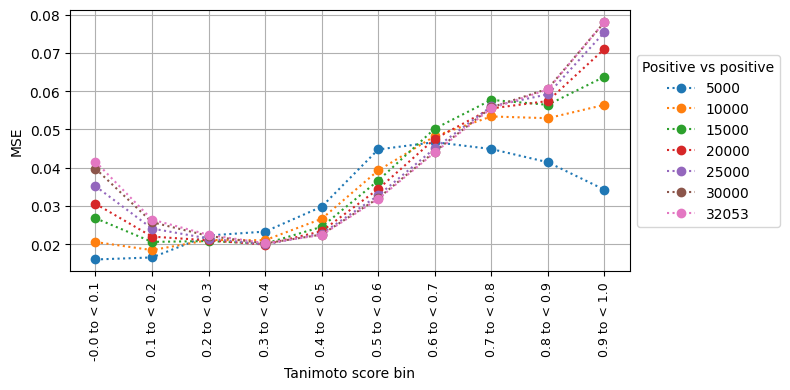

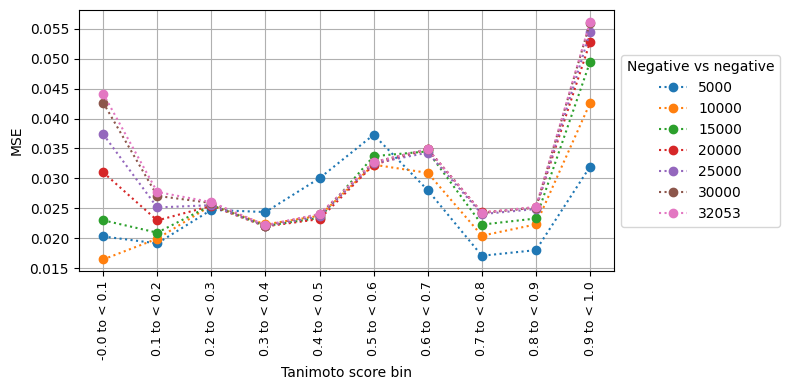

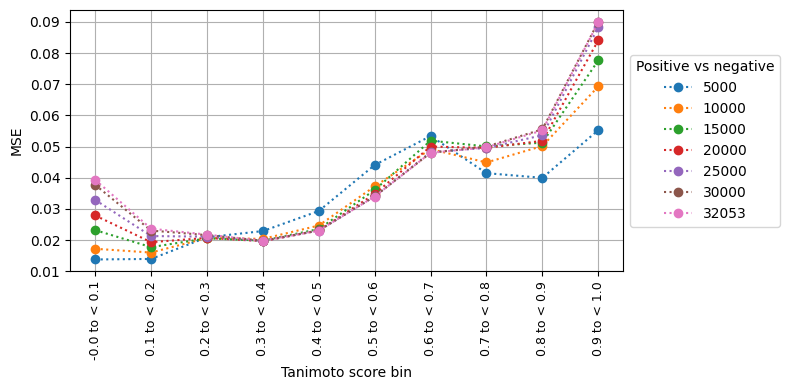

In [11]:
plot_loss_per_bin_per_nr_of_spectra([scores.pos_vs_pos_scores for scores in scores_per_nr_of_spectra.values()], 10, "MSE", "Positive vs positive", save_fig="./figures_embedding_evaluator/MSE_per_bin_pos_pos.svg")
plot_loss_per_bin_per_nr_of_spectra([scores.neg_vs_neg_scores for scores in scores_per_nr_of_spectra.values()], 10, "MSE", "Negative vs negative", save_fig="./figures_embedding_evaluator/MSE_per_bin_pos_neg.svg")
plot_loss_per_bin_per_nr_of_spectra([scores.pos_vs_neg_scores for scores in scores_per_nr_of_spectra.values()], 10, "MSE", "Positive vs negative", save_fig="./figures_embedding_evaluator/MSE_per_bin_neg_neg.svg")

# plot average over 10 bins

In [12]:
from ms2deepscore.utils import create_evenly_spaced_bins

ref_score_bins = create_evenly_spaced_bins(10)
avg_over_bins_per_nr_of_spectra_pos_pos = {}
avg_over_bins_per_nr_of_spectra_pos_neg = {}
avg_over_bins_per_nr_of_spectra_neg_neg = {}

for nr_of_spectra, scores in scores_per_nr_of_spectra.items():
    print(nr_of_spectra)
    counts, avg_scores_per_bin = scores.pos_vs_pos_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_pos_pos[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.pos_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_pos_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.neg_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_neg_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)

5000


Selecting available inchikey pairs per bin: 10it [00:00, 302.63it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 22.68it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 512.81it/s]


10000


Selecting available inchikey pairs per bin: 10it [00:00, 15.02it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 35.95it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 289.07it/s]


15000


Selecting available inchikey pairs per bin: 10it [00:00, 67.21it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 137.11it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 32.18it/s]


20000


Selecting available inchikey pairs per bin: 10it [00:00, 37.92it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 70.15it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 180.11it/s]


25000


Selecting available inchikey pairs per bin: 10it [00:00, 28.60it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 86.23it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 167.38it/s]


30000


Selecting available inchikey pairs per bin: 10it [00:00, 30.78it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 92.34it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 142.47it/s]


32053


Selecting available inchikey pairs per bin: 10it [00:00, 42.39it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 64.24it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 215.70it/s]


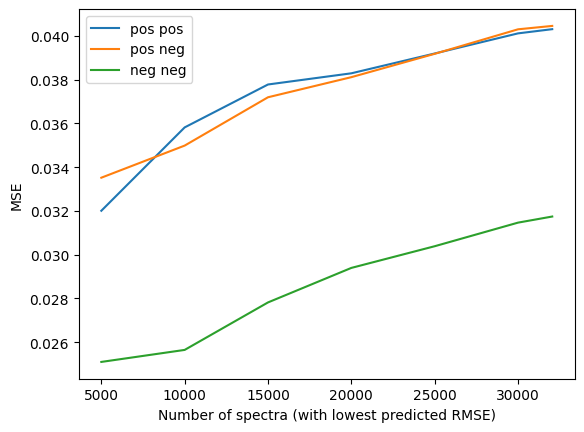

In [13]:
plt.plot(list(avg_over_bins_per_nr_of_spectra_pos_pos.keys()), list(avg_over_bins_per_nr_of_spectra_pos_pos.values()), label = "pos pos")
plt.plot(list(avg_over_bins_per_nr_of_spectra_pos_neg.keys()), list(avg_over_bins_per_nr_of_spectra_pos_neg.values()), label = "pos neg")
plt.plot(list(avg_over_bins_per_nr_of_spectra_neg_neg.keys()), list(avg_over_bins_per_nr_of_spectra_neg_neg.values()), label = "neg neg")
plt.ylabel("MSE")
plt.xlabel("Number of spectra (with lowest predicted RMSE)")
plt.legend()
plt.savefig("./figures_embedding_evaluator/MSE_per_number_of_spectra.svg", bbox_inches="tight")
plt.show()


# Compare to real MSE

#### Calculate real mse

In [14]:
from ms2deepscore.validation_loss_calculation.calculate_scores_for_validation import create_embedding_matrix_symmetric, calculate_tanimoto_scores_unique_inchikey
from ms2deepscore.validation_loss_calculation.PredictionsAndTanimotoScores import PredictionsAndTanimotoScores

predictions_df = create_embedding_matrix_symmetric(MS2DeepScore(ms2ds_model), combined_spectra)

tanimoto_scores_df = calculate_tanimoto_scores_unique_inchikey(combined_spectra, combined_spectra,
                                                               fingerprint_type="daylight", nbits=4096)

tanimoto_scores_df_aligned = tanimoto_scores_df.reindex(index=predictions_df.index, columns=predictions_df.columns)
losses = (predictions_df - tanimoto_scores_df_aligned) ** 2
real_mse = losses.mean(axis=1).tolist()

Calculating embeddings


32053it [01:22, 390.61it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2705/2705 [00:14<00:00, 186.98it/s]


Calculating tanimoto scores


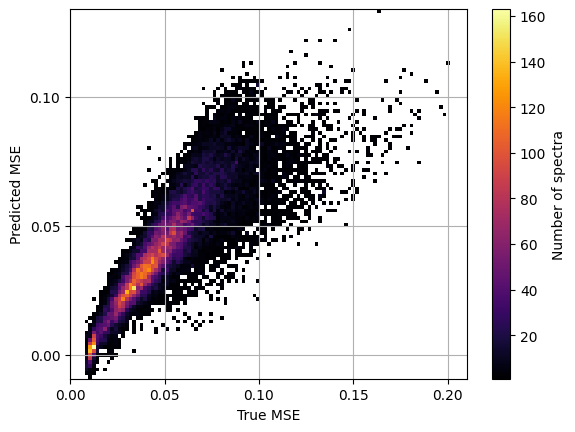

In [15]:
plt.hist2d(real_mse, predicted_mse, bins=100, cmap='inferno',cmin=1)
plt.colorbar(label='Number of spectra')
plt.xlabel("True MSE")
plt.ylabel("Predicted MSE")
# plt.ylim((-0.02, 0.23))
plt.xlim((0, 0.21))
# Linear fit
# coefficients = np.polyfit(real_mse, predicted_mse, 1)
# linear_fit = np.poly1d(coefficients)
# x_values = np.linspace(-0.02, 0.23, 100)
# plt.plot(x_values, linear_fit(x_values), color='red', linestyle='--', label='Linear Fit')
plt.grid()
plt.xticks((0, 0.05, 0.1, 0.15, 0.20))
plt.yticks((0, 0.05, 0.1))
plt.savefig("./figures_embedding_evaluator/predicted_mse_vs_true_mse.svg", bbox_inches="tight")
plt.show()

# Compare to filtering on number of peaks
Below we analyze what filtering on number of peaks would have as effect

In [ ]:
scores_per_min_peaks = {}

for min_nr_of_peaks in range(1, 10):
    selected_pos_spectra = []
    for spectrum in pos_test_spectra:
        if len(spectrum.mz) >= min_nr_of_peaks:
            selected_pos_spectra.append(spectrum)
    print(len(selected_pos_spectra))
    selected_neg_spectra = []
    for spectrum in neg_test_spectra:
        if len(spectrum.mz) >= min_nr_of_peaks:
            selected_neg_spectra.append(spectrum)
    print(len(selected_neg_spectra))

    scores_per_min_peaks[min_nr_of_peaks] = CalculateScoresBetweenAllIonmodes(os.path.join(data_folder, both_mode_folder, "ms2deepscore_model.pt"), 
                                                                      selected_pos_spectra, selected_neg_spectra)


In [ ]:
from ms2deepscore.utils import create_evenly_spaced_bins

ref_score_bins = create_evenly_spaced_bins(10)
avg_over_bins_per_nr_of_spectra_pos_pos = {}
avg_over_bins_per_nr_of_spectra_pos_neg = {}
avg_over_bins_per_nr_of_spectra_neg_neg = {}

for nr_of_spectra, scores in scores_per_min_peaks.items():
    print(nr_of_spectra)
    counts, avg_scores_per_bin = scores.pos_vs_pos_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_pos_pos[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.pos_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_pos_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.neg_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_per_nr_of_spectra_neg_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)

In [ ]:
plt.plot(list(avg_over_bins_per_nr_of_spectra_pos_pos.keys()), list(avg_over_bins_per_nr_of_spectra_pos_pos.values()), label = "pos pos")
plt.plot(list(avg_over_bins_per_nr_of_spectra_pos_neg.keys()), list(avg_over_bins_per_nr_of_spectra_pos_neg.values()), label = "pos neg")
plt.plot(list(avg_over_bins_per_nr_of_spectra_neg_neg.keys()), list(avg_over_bins_per_nr_of_spectra_neg_neg.values()), label = "neg neg")
plt.ylabel("RMSE")
plt.xlabel("Number of peaks")
plt.legend()
plt.show()

To make it easier to compare the two plots, we should remove an equal amount of spectra


In [183]:
print("nr of spectra with at least 9 peaks")
print(len(scores_per_min_peaks[9].negative_validation_spectra) + len(scores_per_min_peaks[9].postive_validation_spectra))

nr of spectra with at least 9 peaks
20905


# Compare with entropy score

In [203]:
import numpy as np
def calculate_spectral_entropy(spectrum):
    spectral_entropy = 0
    for intensity in spectrum.intensities:
        if intensity != 0:
            spectral_entropy -= intensity * np.log(intensity)
    return spectral_entropy
spectral_entropies = []
for spectrum in tqdm(combinned_spectra):
    spectral_entropies.append(calculate_spectral_entropy(spectrum))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32963/32963 [00:01<00:00, 19606.23it/s]


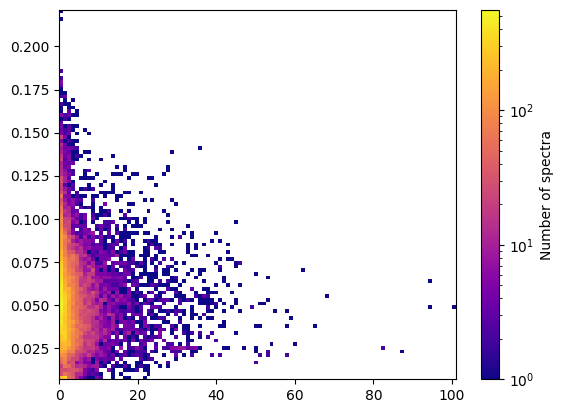

In [441]:
plt.hist2d(spectral_entropies, real_mse, bins=100, cmap='plasma',norm=LogNorm())
plt.colorbar(label='Number of spectra')
plt.show()

### Select different numbers of spectra based on entropy score

In [231]:
# the difference with the function above is that we reverse the entropy scores (becasue low is worse here)
def select_nr_of_spectra_entropy(predicted_entropy, nr_of_spectra, combinned_spectra):
    sorted_indexes = list(reversed(predicted_entropy.argsort()))
    selected_spectra = [combinned_spectra[index] for index in sorted_indexes[:nr_of_spectra]]

    selected_pos_spectra = []
    selected_neg_spectra = []
    for spectrum in selected_spectra:
        if spectrum.get("ionmode") == "positive":
            selected_pos_spectra.append(spectrum)
        else:
            selected_neg_spectra.append(spectrum)
    selected_scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(os.path.join(data_folder, both_mode_folder, "ms2deepscore_model.pt"), 
                                                                      selected_pos_spectra, selected_neg_spectra)
    return selected_scores_between_ionmodes

In [232]:
scores_per_entropy = {}
for nr_of_spectra in range(5000, 36000, 5000):
    print(nr_of_spectra)
    scores_per_entropy[nr_of_spectra] = select_nr_of_spectra_entropy(np.array(spectral_entropies), nr_of_spectra, combinned_spectra)

5000


/lustre/BIF/nobackup/jonge094/ms2deepscore/ms2deepscore/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(filen

Calculating embeddings


4244it [00:06, 615.51it/s]
756it [00:00, 789.09it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 370.51it/s]


Calculating tanimoto scores
Calculating embeddings


4244it [00:05, 786.78it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:02<00:00, 388.97it/s]


Calculating tanimoto scores
Calculating embeddings


756it [00:00, 791.58it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 365.05it/s]


Calculating tanimoto scores
10000
Calculating embeddings


8122it [00:10, 801.29it/s]
1878it [00:02, 792.76it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:01<00:00, 389.54it/s]


Calculating tanimoto scores
Calculating embeddings


8122it [00:10, 801.77it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1308/1308 [00:03<00:00, 414.02it/s]


Calculating tanimoto scores
Calculating embeddings


1878it [00:02, 787.93it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 455/455 [00:01<00:00, 384.40it/s]


Calculating tanimoto scores
15000
Calculating embeddings


11970it [00:14, 818.94it/s]
3030it [00:03, 805.90it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:01<00:00, 405.46it/s]


Calculating tanimoto scores
Calculating embeddings


11970it [00:14, 808.52it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1586/1586 [00:03<00:00, 417.70it/s]


Calculating tanimoto scores
Calculating embeddings


3030it [00:03, 794.58it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:01<00:00, 402.44it/s]


Calculating tanimoto scores
20000
Calculating embeddings


15631it [00:19, 812.36it/s]
4369it [00:05, 798.42it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [00:01<00:00, 411.58it/s]


Calculating tanimoto scores
Calculating embeddings


15631it [00:19, 811.97it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1727/1727 [00:04<00:00, 418.54it/s]


Calculating tanimoto scores
Calculating embeddings


4369it [00:05, 797.33it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [00:01<00:00, 411.86it/s]


Calculating tanimoto scores
25000
Calculating embeddings


19314it [00:23, 811.97it/s]
5686it [00:07, 801.40it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:02<00:00, 420.64it/s]


Calculating tanimoto scores
Calculating embeddings


19314it [00:23, 813.17it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1801/1801 [00:04<00:00, 419.96it/s]


Calculating tanimoto scores
Calculating embeddings


5686it [00:07, 796.19it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:02<00:00, 414.94it/s]


Calculating tanimoto scores
30000
Calculating embeddings


22842it [00:28, 813.15it/s]
7158it [00:08, 800.39it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:02<00:00, 416.89it/s]


Calculating tanimoto scores
Calculating embeddings


22842it [00:28, 812.90it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1828/1828 [00:04<00:00, 419.46it/s]


Calculating tanimoto scores
Calculating embeddings


7158it [00:08, 798.92it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:02<00:00, 422.57it/s]


Calculating tanimoto scores
35000
Calculating embeddings


25412it [00:31, 815.44it/s]
7551it [00:09, 797.08it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 411.38it/s]


Calculating tanimoto scores
Calculating embeddings


25412it [00:31, 810.06it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:04<00:00, 419.14it/s]


Calculating tanimoto scores
Calculating embeddings


7551it [00:09, 797.32it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 419.50it/s]


Calculating tanimoto scores


In [234]:
from ms2deepscore.utils import create_evenly_spaced_bins

ref_score_bins = create_evenly_spaced_bins(10)
avg_over_bins_entropy_pos_pos = {}
avg_over_bins_entropy_pos_neg = {}
avg_over_bins_entropy_neg_neg = {}

for nr_of_spectra, scores in scores_per_entropy.items():
    print(nr_of_spectra)
    counts, avg_scores_per_bin = scores.pos_vs_pos_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_entropy_pos_pos[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.pos_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_entropy_pos_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)
    counts, avg_scores_per_bin = scores.neg_vs_neg_scores.get_average_loss_per_bin_per_inchikey_pair("MSE", ref_score_bins)
    avg_over_bins_entropy_neg_neg[nr_of_spectra] = sum(avg_scores_per_bin)/len(avg_scores_per_bin)

5000


Selecting available inchikey pairs per bin: 10it [00:00, 270.41it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 1052.02it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 2971.31it/s]


10000


Selecting available inchikey pairs per bin: 10it [00:00, 113.70it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 354.55it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 1005.03it/s]


15000


Selecting available inchikey pairs per bin: 10it [00:00, 75.56it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 191.32it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 504.09it/s]


20000


Selecting available inchikey pairs per bin: 10it [00:00, 62.87it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 145.24it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 338.14it/s]


25000


Selecting available inchikey pairs per bin: 10it [00:00, 58.18it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 125.84it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 265.22it/s]


30000


Selecting available inchikey pairs per bin: 10it [00:00, 56.43it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 118.31it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 227.14it/s]


32963


Selecting available inchikey pairs per bin: 10it [00:00, 56.14it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 113.55it/s]
Selecting available inchikey pairs per bin: 10it [00:00, 234.39it/s]


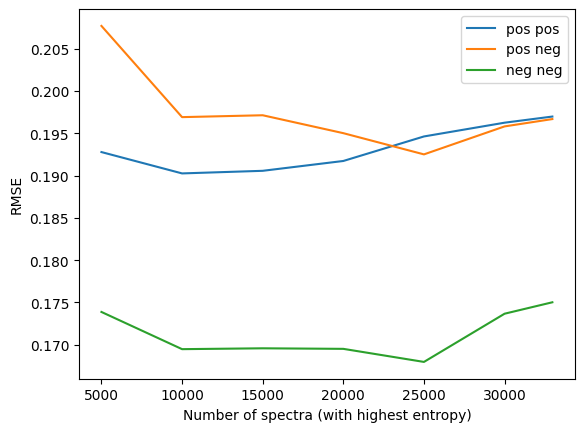

In [236]:
plt.plot(list(avg_over_bins_entropy_pos_pos.keys()), list(avg_over_bins_entropy_pos_pos.values()), label = "pos pos")
plt.plot(list(avg_over_bins_entropy_pos_neg.keys()), list(avg_over_bins_entropy_pos_neg.values()), label = "pos neg")
plt.plot(list(avg_over_bins_entropy_neg_neg.keys()), list(avg_over_bins_entropy_neg_neg.values()), label = "neg neg")
plt.ylabel("MSE")
plt.xlabel("Number of spectra (with highest entropy)")
plt.legend()
plt.show()

# Plot correlation between nr of peaks and predicted MSE

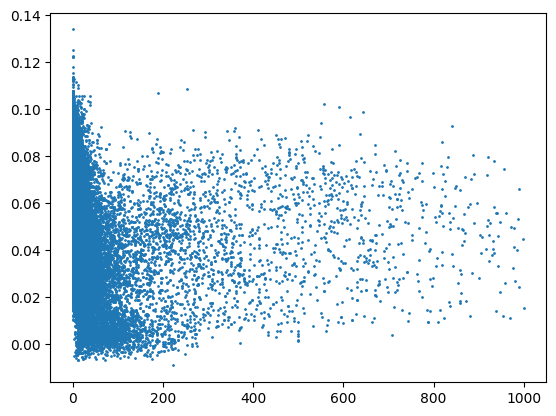

In [16]:
nr_of_peaks = []
for spectrum in combined_spectra:
    nr_of_peaks.append(len(spectrum.mz))
plt.scatter(nr_of_peaks, predicted_mse, s=1)


Since there are too many datapoints to read this plot, we will create a plot where we take the average predicted mse per nr of peaks. 

In [17]:
mse_per_nr_of_peaks = {}
for i, spectrum in enumerate(combined_spectra):
    nr_of_peaks = len(spectrum.mz)
    if nr_of_peaks in mse_per_nr_of_peaks:
        mse_per_nr_of_peaks[nr_of_peaks].append(predicted_mse[i])
    else:
        mse_per_nr_of_peaks[nr_of_peaks] = [predicted_mse[i]]


In [18]:
averages = []
nr_of_peaks_list = []
sizes = []
for nr_of_peaks, rmses in sorted(mse_per_nr_of_peaks.items()):
    averages.append(sum(rmses)/len(rmses))
    sizes.append(len(rmses)/10)
    nr_of_peaks_list.append(nr_of_peaks)

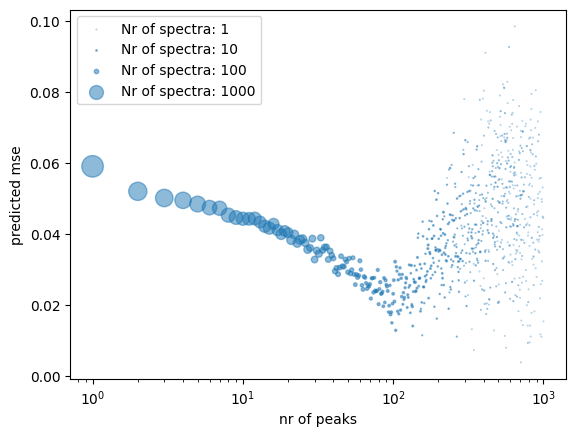

In [19]:
plt.scatter(nr_of_peaks_list, averages, s=sizes, alpha=0.5)
plt.xlabel("nr of peaks")
plt.ylabel("predicted mse")
plt.xscale('log')
legend_nr_of_spectra = [1, 10, 100, 1000]
for size in legend_nr_of_spectra:
    plt.scatter([], [], s=size/10, label=f'Nr of spectra: {size}', color="#1f77b4", alpha=0.5)
plt.legend()
plt.savefig("./figures_embedding_evaluator/predicted_mse_vs_nr_of_peaks.svg")

# relationship with precursor mz
We group all spectra within a bin of 100Da and plot the average. Otherwise there are too many overlapping datapoints. The group_nr_of_spectra can be changed to change the bin size. 

In [21]:
group_nr_of_spectra = 100

mse_per_precursor_mz = {}
for i, spectrum in enumerate(combined_spectra):
    precursor = spectrum.get("precursor_mz")//group_nr_of_spectra*group_nr_of_spectra+group_nr_of_spectra/2
    if precursor in mse_per_precursor_mz:
        mse_per_precursor_mz[precursor].append(predicted_mse[i])
    else:
        mse_per_precursor_mz[precursor] = [predicted_mse[i]]

In [22]:
averages = []
precursors_list = []
sizes = []
for precursor, rmses in sorted(mse_per_precursor_mz.items()):
    averages.append(sum(rmses)/len(rmses))
    sizes.append(len(rmses)/10)
    precursors_list.append(precursor)

In [197]:
precursors = [int(spectrum.get("precursor_mz")) for spectrum in combined_spectra]

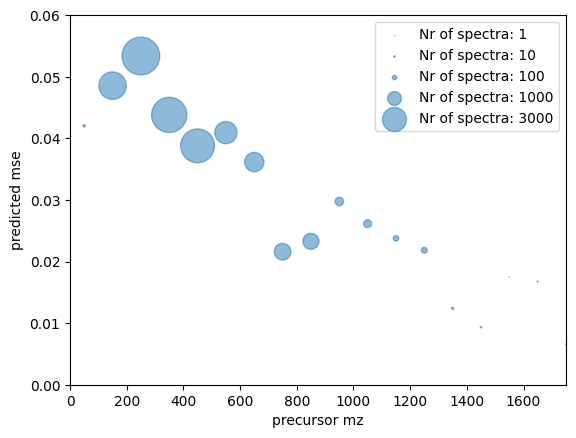

In [23]:
plt.scatter(precursors_list, averages, s=sizes, alpha=0.5)
plt.xlabel("precursor mz")
plt.ylabel("predicted mse")
legend_nr_of_spectra = [1, 10, 100, 1000, 3000]
for size in legend_nr_of_spectra:
    plt.scatter([], [], s=size/10, label=f'Nr of spectra: {size}', color="#1f77b4", alpha=0.5)
plt.legend()
plt.ylim(0, 0.06)
plt.xlim(0, 1750)
plt.savefig("./figures_embedding_evaluator/predicted_mse_vs_precursor_mz.svg")
# Linear fit
# coefficients = np.polyfit(precursors, predicted_mse, 1)
# linear_fit = np.poly1d(coefficients)
# x_values = np.linspace(0,1500, 100)
# plt.plot(x_values, linear_fit(x_values), color='red', linestyle='--', label='Linear Fit')

# Relationship between precursor and number of peaks
To check if precursor mz and number of peaks have a strong correlation

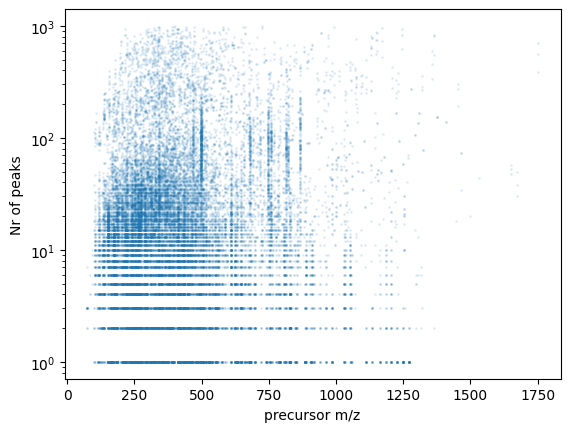

In [20]:
import numpy as np
nr_of_peaks = []
for spectrum in combined_spectra:
    nr_of_peaks.append(len(spectrum.mz))
precursors = [spectrum.get("precursor_mz") for spectrum in combined_spectra]
plt.scatter(precursors, nr_of_peaks, s=1, alpha=0.1)
plt.xlabel("precursor m/z")
plt.ylabel("Nr of peaks")
# plt.xscale('log')
plt.yscale("log")
# Linear fit
# coefficients = np.polyfit(precursors, nr_of_peaks, 1)
# linear_fit = np.poly1d(coefficients)
# x_values = np.linspace(100,1500, 100)
# plt.plot(x_values, linear_fit(x_values), color='red', linestyle='--', label='Linear Fit')
plt.savefig("./figures_embedding_evaluator/precursor_mz_vs_nr_of_peaks.svg")

# Check per compound class? 
We load in classyfire annotations. 

In [24]:
import pandas as pd
compound_classes = pd.read_csv("./compounds_updated.csv")

In [26]:
from tqdm import tqdm
for spectrum in tqdm(combined_spectra):
    inchikey = spectrum.get("inchikey")[:14]
    available_compound_classes = compound_classes[compound_classes['inchikey'] == inchikey]["cf_superclass"]
    selected_compound_class = "Unknown/other"
    if len(available_compound_classes) > 0:
        if len(set(available_compound_classes.tolist())) == 2:
            for compound_class in set(available_compound_classes.tolist()):
                if pd.notna(compound_class):
                    selected_compound_class = compound_class
        if len(set(available_compound_classes.tolist())) > 2:
            raise(ValueError)
        else:
            selected_compound_class = available_compound_classes.tolist()[0]
            if not pd.notna(selected_compound_class):
                selected_compound_class = "Unknown/other"
    spectrum.set("cf_superclass", selected_compound_class)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32053/32053 [02:11<00:00, 244.47it/s]


In [38]:
mse_per_compound_class = {}
for i, spectrum in enumerate(combined_spectra):
    compound_class = spectrum.get("cf_superclass")
    if compound_class in mse_per_compound_class:
        mse_per_compound_class[compound_class].append(real_mse[i])
    else:
        mse_per_compound_class[compound_class] = [real_mse[i]]

In [39]:
for compound_class in list(mse_per_compound_class.keys()):
    if len(mse_per_compound_class[compound_class]) < 300:
        print(compound_class, len(mse_per_compound_class[compound_class]))
        mse_per_compound_class["Unknown/other"].extend(mse_per_compound_class.pop(compound_class))

Homogeneous non-metal compounds 6
Organosulfur compounds 47
Lignans, neolignans and related compounds 141
Organic Polymers 2
Hydrocarbons 102
Organometallic compounds 1
Organohalogen compounds 94


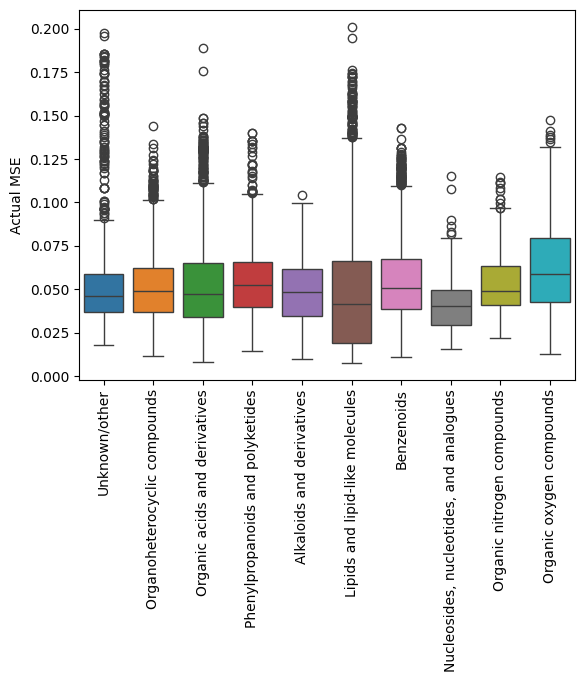

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.boxplot(mse_per_compound_class)
plt.xticks(rotation=90)
plt.ylabel("Actual MSE")
plt.savefig("./figures_embedding_evaluator/actual_mse_vs_compound_class.svg", bbox_inches="tight")

# Adduct

In [41]:
mse_per_charge = {}
for i, spectrum in enumerate(combined_spectra):
    compound_class = spectrum.get("adduct")
    if compound_class in mse_per_charge:
        mse_per_charge[compound_class].append(real_mse[i])
    else:
        mse_per_charge[compound_class] = [real_mse[i]]

In [42]:
adducts_to_plot = {"Other": []}
for adduct, scores in mse_per_charge.items():
    if len(scores) > 100:
        adducts_to_plot[adduct] = scores
    else:
        print(adduct)
        adducts_to_plot["Other"].extend(scores)

[M]+
[M+Li]+
[M+H-NH3]+
[2M+H]+
[2M+Na]+
[M+2Na-H]+
[2M+NH4]+
[M+CH3OH+H]+
[M+2H]2+
[M+ACN+H]+
[M-H2O]+
[M-3H2O+H]+
[2M+K]+
[M+H+K]2+
[M+2K-H]+
[3M+K]+
[3M+Na]+
[2M+Ca]2+
[M+Ca]2+
[M+H-CH4O]+
[M+H+CH3OH]+
[M+H+CH3CN]+
[M+CH3COO]-
[2M-2H+Na]-
[M+HCOO]-
[M+CH3COOH-H]-
[M]-
[M-C2H3O]-
[M+Hac-H]-
[M-2H]-
[M+Na-2H]-
[M+K-2H]-
[M-CH3]-
[3M-H]-
[M-H+HCOOH]-
[M-2H+Na]-
[M-H+CH3OH]-


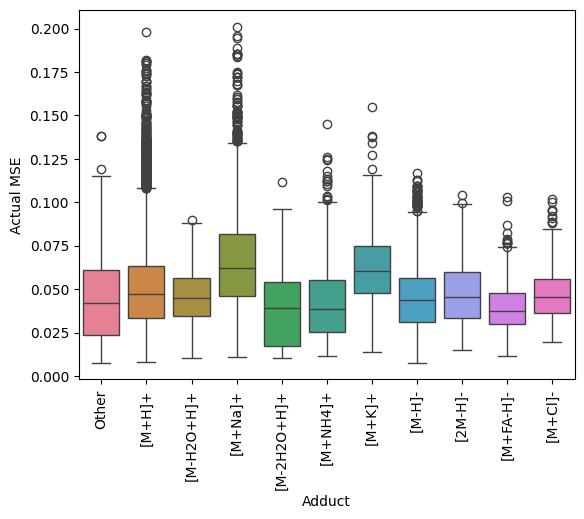

In [43]:
sns.boxplot(adducts_to_plot)
plt.xticks(rotation=90)
plt.ylabel("Actual MSE")
plt.xlabel("Adduct")
plt.savefig("./figures_embedding_evaluator/actual_mse_vs_adduct.svg", bbox_inches="tight")

# Test for randomly generated spectra
Below we generate random spectra. This helps us to get an insight in what influences the distribution of spectra. 

In [44]:
from matchms.Spectrum import Spectrum
import numpy as np

def plot_predicted_mse_random_noise(nr_of_peaks=10, intensity_normalization= 1, nr_of_spectra = 1000, ionmode="positive", precursor_mz=None, mz_spread=990, min_mz=10):
    random_noise_spectra = []
    for _ in range(nr_of_spectra):
        intensities = np.random.rand(nr_of_peaks) * intensity_normalization
        mz = np.random.rand(nr_of_peaks)*mz_spread + min_mz
        mz = np.array(sorted(mz))
        if precursor_mz is None:
            precursor = np.random.rand(1)*1000
            precursor = precursor[0]
        else: 
            precursor = precursor_mz
        
        random_noise_spectra.append(Spectrum(mz=mz, intensities=intensities,  metadata={"precursor_mz": precursor, "ionmode": ionmode,}))
    predicted_mse_random_noise = get_predicted_mse(ms2ds_model, ms2ds_embedding_evaluator, random_noise_spectra)
    return predicted_mse_random_noise

In [45]:
box_plot_data = {}


In [46]:
box_plot_data["Number of fragments"] = {}
random_noise_results = {"normal distribution": predicted_mse}
for nr_of_peaks in (1, 10, 100, 1000, 10000):
    box_plot_data["Number of fragments"][nr_of_peaks] = plot_predicted_mse_random_noise(nr_of_peaks = nr_of_peaks)

1000it [00:01, 643.13it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.05it/s]
1000it [00:01, 786.58it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 29.48it/s]
1000it [00:01, 785.91it/s]
100%|████████████████████████████████████████████████████████████████████

In [47]:
box_plot_data["Intensity normalization"] = {}
for intensity_normalization in (0.001, 0.01, 0.1, 0.5, 1.0):
    box_plot_data["Intensity normalization"][intensity_normalization] = plot_predicted_mse_random_noise(intensity_normalization = intensity_normalization)

1000it [00:01, 757.30it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s]
1000it [00:01, 808.84it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.70it/s]
1000it [00:01, 826.82it/s]
100%|████████████████████████████████████████████████████████████████████

In [48]:
box_plot_data["Ionmode"] = {}

random_noise_results_ionmode = {}
for ionmode in ("positive", "negative"):
    box_plot_data["Ionmode"][ionmode] = plot_predicted_mse_random_noise(ionmode=ionmode)

1000it [00:01, 812.53it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.26it/s]
1000it [00:01, 802.82it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.31it/s]


In [49]:
box_plot_data["Precursor m/z"] = {}
random_noise_results_precursor_mz = {}
for precursor_mz in (100, 300, 500, 700, 900):
    box_plot_data["Precursor m/z"][precursor_mz] = plot_predicted_mse_random_noise(precursor_mz=precursor_mz)

1000it [00:01, 798.93it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.84it/s]
1000it [00:01, 865.30it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.53it/s]
1000it [00:01, 806.67it/s]
100%|████████████████████████████████████████████████████████████████████

In [50]:
box_plot_data["Smallest fragment m/z"] = {}
for min_mz in (10, 100, 300, 500, 800):
    box_plot_data["Smallest fragment m/z"][min_mz] = plot_predicted_mse_random_noise(100, mz_spread=100, min_mz=min_mz, precursor_mz=None)

1000it [00:01, 793.43it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.94it/s]
1000it [00:01, 811.99it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.43it/s]
1000it [00:01, 827.79it/s]
100%|████████████████████████████████████████████████████████████████████

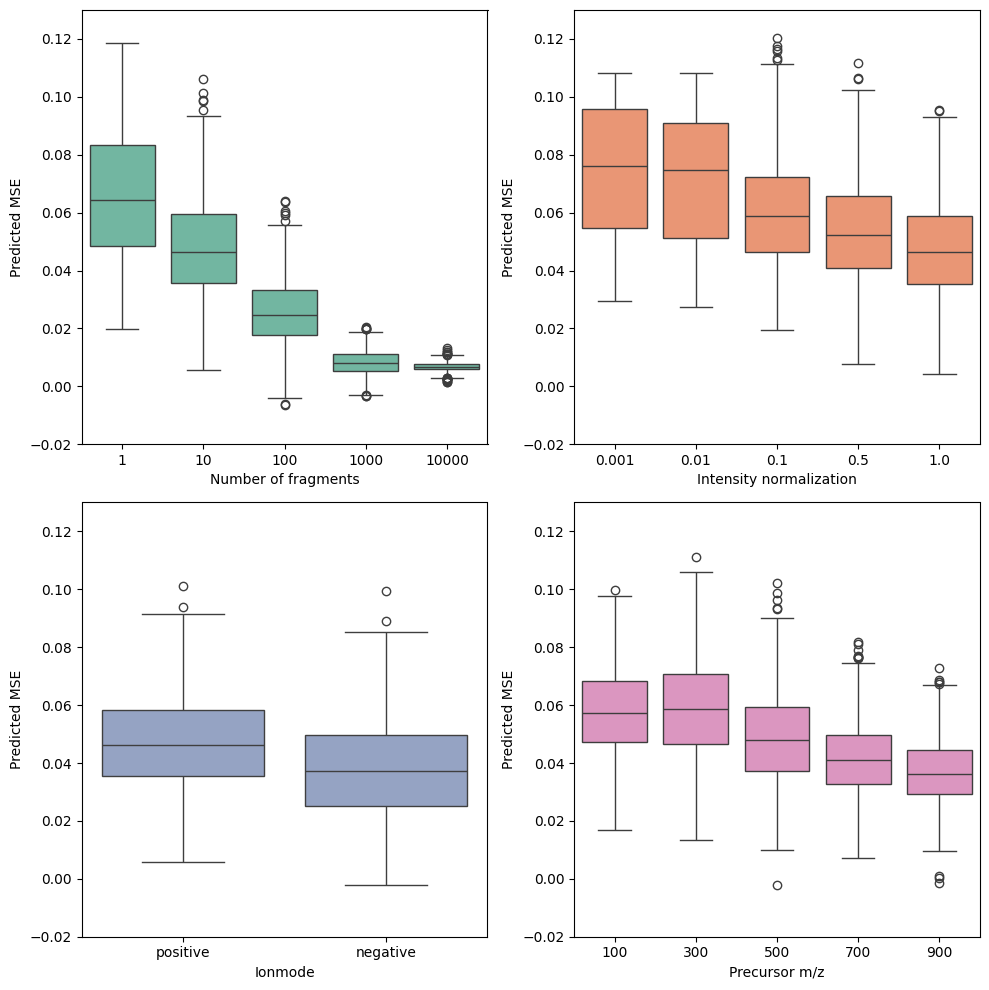

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    selected_box_plot_title = list(box_plot_data.keys())[i]
    selected_box_plot_data = box_plot_data[selected_box_plot_title]
    sns.boxplot(selected_box_plot_data, ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_xlabel(selected_box_plot_title)
    ax.set_ylabel("Predicted MSE")
    ax.set_ylim((-0.02, 0.13))
fig.tight_layout()
plt.savefig("./figures_embedding_evaluator/predicted_mse_vs_randomly_generated_spectra.svg")